### Test - Synthetic Diagnostic + Interferometry

</b> Author:   </b>  Louis Evans     </br>
</b> Reviewer: </b>  Stefano Merlini

### Import relevant files:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import vtk
from vtk.util import numpy_support as vtk_np
import matplotlib.pyplot as plt

import sys

#add path
sys.path.insert(0, '../../synthPy_restructured')     # import path/to/synthpy

import beam as beam_initialiser
import diagnostics as diag
import domain as d
import propagator as p
#import propagator_backup_non_jax as p
import utils

import importlib
importlib.reload(beam_initialiser)
importlib.reload(diag)
importlib.reload(d)
importlib.reload(p)
importlib.reload(utils)

<module 'utils' from 'c:\\Users\\samma\\programming\\synthPy\\examples\\notebooks\\../../synthPy_restructured\\utils.py'>

To use the ray tracer, first create a 'domain', load the domain with an electron distribution, calculate electron gradients, initialise a beam, and solve!
\
\
The output can either be plotted, or passed further through ray optics for synthetic diagnostics

In [2]:
# define some extent, the domain should be distributed as +extent to -extent, does not need to be cubic
extent_x = 5e-3
extent_y = 5e-3
extent_z = 10e-3

n_cells = 1000

x = np.linspace(-extent_x, extent_x, n_cells)
y = np.linspace(-extent_y, extent_y, n_cells)
z = np.linspace(-extent_z, extent_z, n_cells)

probing_extent = extent_z
probing_direction = 'z'

lengths = 2 * np.array([extent_x, extent_y, extent_z])

#domain = d.ScalarDomain(x = x, y = y, z = z, extent= probing_extent, probing_direction = probing_direction)     # create domain
# Much simpler domain function, no longer needlessly takes in beam values, they are fully seperated
domain = d.ScalarDomain(lengths, n_cells) # B_on = False by default

Load some domain distribution

In [3]:
# load some external pvti
# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)
# or load a test distribution

#domain.ne = np.full((100, 100, 100), 1e24)
domain.test_exponential_cos()
#domain.test_slab(0.000001, 1e24)

Solve gradients, initialise beam, and solve

In [ ]:
wl = 1064e-9 #define laser wavelength

# initialise beam
Np = 1    # number of photons
divergence = 5e-5   # realistic divergence value
beam_size = extent_x    # beam radius
ne_extent = probing_extent  # so the beam knows where to initialise initial positions
beam_type = 'circular'

initial_rays = beam_initialiser.Beam(Np, beam_size, divergence, ne_extent, probing_direction, wl, beam_type)

tracer = p.Propagator(domain, initial_rays, inv_brems = False, phaseshift = False)

# solve ray trace
tracer.calc_dndr()
final_rays = tracer.solve(parallelise = True, jitted = True)
#final_rays, final_rays_to_Jonesvector = tracer.Beam.rf, tracer.Beam.Jf
print("\nCompleted ray trace in", np.round(tracer.duration, 3), "seconds.")

'''
tracer1 = p.Propagator(domain, initial_rays, inv_brems = False, phaseshift = False)
tracer1.calc_dndr()
final_rays1 = tracer1.solve(parallelise = False, jitted = False)
print("\nCompleted ray trace in", np.round(tracer.duration, 3), "seconds.")

print(tracer.Beam.rf - tracer1.Beam.rf)
'''

'''
Available devices: [CpuDevice(id=0)]

jax compilation of solver took: 0.0017893314361572266
Running device: cpu, with: 4 cores.
c:\Users\samma\AppData\Local\Programs\Python\Python313\Lib\site-packages\jax\_src\interpreters\mlir.py:1135: UserWarning: A large amount of constants were captured during lowering (12.00GB total). If this is intentional, disable this warning by setting JAX_CAPTURED_CONSTANTS_WARN_BYTES=-1. To obtain a report of where these constants were encountered, set JAX_CAPTURED_CONSTANTS_REPORT_FRAMES=-1.
  warnings.warn(message)
---------------------------------------------------------------------------
MemoryError                               Traceback (most recent call last)
Cell In[4], line 16
     14 # solve ray trace
     15 tracer.calc_dndr()
---> 16 final_rays = tracer.solve(parallelise = True, jitted = True)
     17 #final_rays, final_rays_to_Jonesvector = tracer.Beam.rf, tracer.Beam.Jf
     18 print("\nCompleted ray trace in", np.round(tracer.duration, 3), "seconds.")

File c:\Users\samma\programming\synthPy\examples\notebooks\../../synthPy_restructured\propagator.py:297, in Propagator.solve(self, return_E, parallelise, jitted)
    292 args = (self, parallelise) # passed args must be hashable to be made static for jax.jit, tuple is hashable, array & dict are not
    294 # pass s0[:, i] for each ray via a jax.vmap for parallelisation
    295 # transposed as jax.vmap() expects form of [batch_idx, items] not [items, batch_idx]
    296 # remove unnecessary static arguments to increase speed and reduce likelihood of unexpected behaviours
--> 297 sol = jax.vmap(lambda s: ODE_solve(s, args))(s0.T)
    299 jax.debug.visualize_array_sharding(sol.ys[:, -1, :])
    301 path = "../../evaluation/memory_benchmarks/memory-domain" + str(s0.shape[1]) + "_rays-" + datetime.now().strftime("%Y%m%d-%H%M%S") + ".prof"

    [... skipping hidden 7 frame]

File c:\Users\samma\programming\synthPy\examples\notebooks\../../synthPy_restructured\propagator.py:297, in Propagator.solve.<locals>.<lambda>(s)
    292 args = (self, parallelise) # passed args must be hashable to be made static for jax.jit, tuple is hashable, array & dict are not
    294 # pass s0[:, i] for each ray via a jax.vmap for parallelisation
    295 # transposed as jax.vmap() expects form of [batch_idx, items] not [items, batch_idx]
    296 # remove unnecessary static arguments to increase speed and reduce likelihood of unexpected behaviours
...
    387       executable_devices=executable_devices,
    388       compile_options=options,
    389   )

MemoryError: bad allocation
Output is truncated. View as a scrollable element or open in a text editor. Adjust cell output settings...
'''


Available devices: [CpuDevice(id=0)]

jax compilation of solver took: 0.0017893314361572266
Running device: cpu, with: 4 cores.


c:\Users\samma\AppData\Local\Programs\Python\Python313\Lib\site-packages\jax\_src\interpreters\mlir.py:1135: UserWarning: A large amount of constants were captured during lowering (12.00GB total). If this is intentional, disable this warning by setting JAX_CAPTURED_CONSTANTS_WARN_BYTES=-1. To obtain a report of where these constants were encountered, set JAX_CAPTURED_CONSTANTS_REPORT_FRAMES=-1.
  warnings.warn(message)


MemoryError: bad allocation

Pass through ray optics: For Shadowgaphy, Schlieren, or Refractometry:


rf size expected: (100, 100)
rf after clearing nan's: (83, 83)


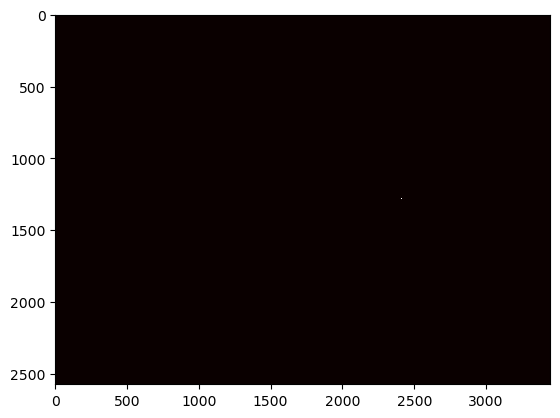

In [ ]:
#in the diagnostic initialisation, details on the lens configurations, and detector dimensions can be specified
refractometer = diag.Refractometry(tracer.Beam)
refractometer.incoherent_solve()
# cam't clear_mem if you want to generate other graphs afterwards
refractometer.histogram(bin_scale = 1, clear_mem = False)

#information accessed by .H(istogram) , e.g plt.imshow(refractometer.H)

#plt.imshow(refractometer.H, cmap='hot', interpolation='nearest', clim = (0, 2))
plt.imshow(refractometer.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))


rf size expected: (100, 100)
rf after clearing nan's: (83, 83)


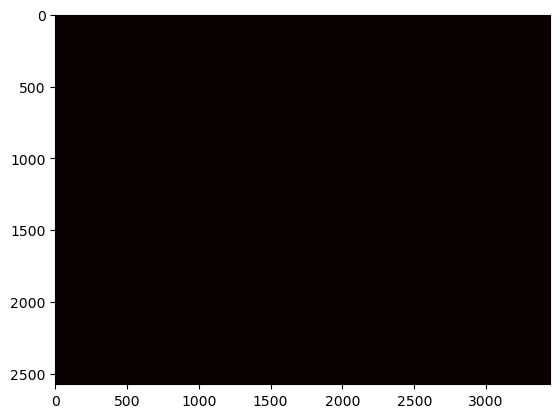

In [ ]:
shadowgrapher = diag.Shadowgraphy(tracer.Beam)
shadowgrapher.single_lens_solve()
shadowgrapher.histogram(bin_scale = 1, clear_mem = False)

plt.imshow(shadowgrapher.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))


rf size expected: (100, 100)
rf after clearing nan's: (61, 61)


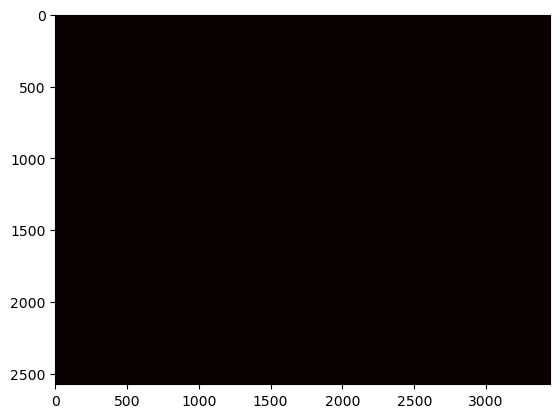

In [ ]:
schlierener = diag.Schlieren(tracer.Beam)
schlierener.DF_solve()
schlierener.histogram(bin_scale = 1, clear_mem = True)

plt.imshow(schlierener.H, cmap = 'hot', interpolation = 'nearest', clim = (0.5, 1))

Synthetic Interferometry - This requires some extra steps in the ray tracing to include information on the phase and electric field values

In [ ]:
# No need to change the domain (now that code has been seperated out in restructure)



# load some external pvti

# import utils.handle_filetypes as load
# ne, dim, spacing = load.pvti_readin(filename)

# or load a test distribution



# initialise beam



# solve ray trace
tracer = p.Propagator(domain, initial_rays, inv_brems = False, phaseshift = True)

tracer.calc_dndr()

tracer.Beam.rf, tracer.Beam.Jf = tracer.solve(parallelise = False, jitted = False, return_E = True)

n_fringes = 10
deg = 10 #adjust number of fringes and tilt in degrees from the vertical exis

interferometrer = diag.Interferometry(tracer.Beam)
interferometrer.interfere_ref_beam(n_fringes, deg)

pattern = diag.Interferometry(tracer.Beam)
#pattern = interferometrer
pattern.two_lens_solve()
pattern.interferogram(bin_scale = 1, clear_mem = True) #use interferogram instead of histogram

#get interferogram histogram with sh.H



x-y size expected: (100, 100)
Final rays: [[-7.91867030e-04 -4.88584146e-03 -3.79739770e-03 -3.02315830e-04
  -1.81109255e-03 -2.33571493e-03 -1.36657404e-03  9.90940609e-06
   1.10876133e-03  1.68338786e-03  1.17785994e-03  2.36153684e-04
   3.62331103e-04 -5.93110645e-03 -1.54210870e-04 -4.02544331e-04
   2.72030439e-03 -1.62052505e-03 -4.37156917e-03  3.81930703e-05
   1.00964370e-03 -1.66810172e-03  1.13061673e-04 -9.32806956e-04
   3.84663754e-04  1.66501079e-04 -1.05342380e-03  3.22597745e-04
  -6.30013323e-04 -7.87473217e-05  7.23014500e-04  5.81935413e-04
   3.72495380e-04 -1.05185044e-03 -1.03460944e-03 -3.29770538e-03
   6.88071737e-04  1.41719296e-03 -1.94080948e-03 -4.49026117e-04
  -2.33545956e-03 -2.74357303e-03 -2.20153940e-03 -2.89493083e-03
  -4.23017243e-05 -6.99683255e-04 -2.02871767e-03 -1.16872289e-03
  -9.87044491e-04 -1.06824452e-03 -5.91134007e-04 -2.80051209e-04
  -1.80230506e-04  1.41931072e-03  5.49528476e-04 -2.14801222e-04
  -1.37847533e-03  2.63124564e-03

AttributeError: 'numpy.ndarray' object has no attribute 'at'

In [ ]:
plt.imshow(pattern.H, cmap = 'hot', interpolation = 'nearest')

AttributeError: 'Interferometry' object has no attribute 'H'